In [266]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from collections import Counter
import matplotlib.patches as mpatches

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing, neighbors, grid_search, cross_validation, linear_model, feature_selection, decomposition, cluster, ensemble, metrics, externals

## Game of Thrones - Predicting Character Deaths

'Valar Morghulis' - a well-known greeting in the popular TV series Game of Thrones can be used to sum up the violence in the series. It translates to "All men must die". 

The purpose of this project is to see if the character fatalities come at random or if it only comes to those selected ones who exhibit similar features such as demographics, popularity...etc. The Song of Ice and Fire series and the corresponding Game of Thrones TV series is notorious for killing many major characters. The high death tolls will hopefully give me enough of a sample size to make interesting observations. 

My knowledge of this topic comes from watching the Game of Thrones TV show like most people, reading the books, and waiting for the next book - Winds of Winter with bated breath.

In [267]:
predictions = pd.read_csv(os.path.join('datasets','character-predictions.csv'))

In [268]:
predictions.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


### Explorational analysis (initial look at the data)

In [269]:
predictions.describe()

,S.No,actual,pred,alive,plod,male,dateOfBirth,DateoFdeath,book1,book2,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,433.000000,444.000000,1946.000000,1946.000000,...,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,973.500000,0.745632,0.687050,0.634470,0.365530,0.619219,1577.364896,2950.193694,0.198356,0.374615,...,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.074512,0.059096,0.089584,0.745632
std,561.906131,0.435617,0.463813,0.312637,0.312637,0.485704,19565.414460,28192.245529,0.398864,0.484148,...,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.262669,0.235864,0.160568,0.435617
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,487.250000,0.000000,0.000000,0.391250,0.101000,0.000000,NaN,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.013378,0.000000
50%,973.500000,1.000000,1.000000,0.735500,0.264500,1.000000,NaN,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.033445,1.000000
75%,1459.750000,1.000000,1.000000,0.899000,0.608750,1.000000,NaN,NaN,0.000000,1.000000,...,NaN,NaN,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.086957,1.000000
max,1946.000000,1.000000,1.000000,1.000000,1.000000,1.000000,298299.000000,298299.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000


In [270]:
predictions.columns

Index([u'S.No', u'actual', u'pred', u'alive', u'plod', u'name', u'title',
       u'male', u'culture', u'dateOfBirth', u'DateoFdeath', u'mother',
       u'father', u'heir', u'house', u'spouse', u'book1', u'book2', u'book3',
       u'book4', u'book5', u'isAliveMother', u'isAliveFather', u'isAliveHeir',
       u'isAliveSpouse', u'isMarried', u'isNoble', u'age', u'numDeadRelations',
       u'boolDeadRelations', u'isPopular', u'popularity', u'isAlive'],
      dtype='object')

Looking at the dataset, there are a ton of missing data that will interfere with model building. Therefore I've decided to drop a chunk of minor characters by eliminating those that do not belong to a house.

In [271]:
#dropping minor characters by eliminating those that do not belong to a house.
predictions.dropna(subset=['house'], inplace=True)

In [272]:
#I would also like to drop other columns that I'd prefer to not look at. 
predictions.drop(predictions.columns[[0,1,2,3,4,9,10]],inplace=True,axis=1)

In [273]:
predictions.head()

,name,title,male,culture,mother,father,heir,house,spouse,book1,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
1,Walder Frey,Lord of the Crossing,1,Rivermen,NaN,NaN,NaN,House Frey,Perra Royce,1,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,House Swyft,NaN,0,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,Aemma Arryn,Queen,0,NaN,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,Sylva Santagar,Greenstone,0,Dornish,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1
6,Valarr Targaryen,Hand of the King,1,Valyrian,NaN,NaN,NaN,House Targaryen,Kiera of Tyrosh,0,...,NaN,1.0,1,1,26.0,0,0,1,0.431438,0


In [274]:
#The dataset has become smaller and more concise
predictions.shape

(1519, 26)

### Explorational analysis (choosing the independant and dependant variables)

I will be using 'isAlive' as my independant variable and possibly 'name' as my index since I am trying to predict the likelihood of death. The following is a list of features that I believe should be informative. 

Feature | Explanation
---|---|
book5 | Character's appearance in the book 
book4 | Character's appearance in the book
book3 | Character's appearance in the book 
book2 | Character's appearance in the book
book1 | Character's appearance in the book 
culture| Social group to which a character belongs
IsNoble |	Character's nobility based on Title
male	| Whether the character is male or not
title	| Social status or nobility
age | Character's age  
house | Represents the family that the character pays allegiance to
boolDeadRelations| Represents whether a character is related to another dead character
popularity | A score of how popular a character is	
isMarried | Represents whether the character is married
isAliveSpouse | Represents whether character's spouse is alive
isAliveFather | Represents whether character's father is alive
isAliveMother | Represents whether character's mother is alive
isAliveHeir  | Represents whether character's heir is alive
numDeadRelations |	Number of dead characters to whom a character is related

### Are women more likely to survive than men?

It turns out that women are more likely to survive than men. This is maybe due to the fact that there are less women that participates in battles between houses. 

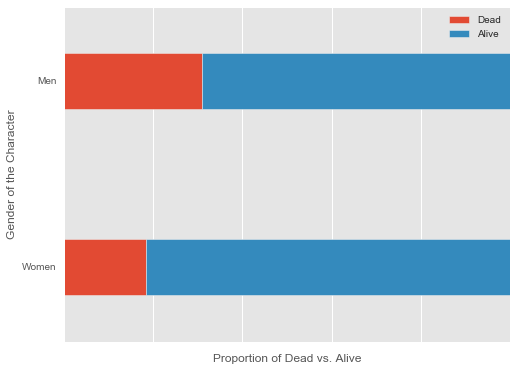

In [275]:
data = predictions.groupby(["male", "isAlive"]).count()["name"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .3, figsize=(8,6))
_ = p.set(yticklabels = ["Women", "Men"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Gender of the Character"), p.legend(["Dead", "Alive"])

### Does being noble mean you're more likely to die?

Looks like being noble actually means you're more likely to die, whereas the survival rates are quite similar between the nobility and the commoners.

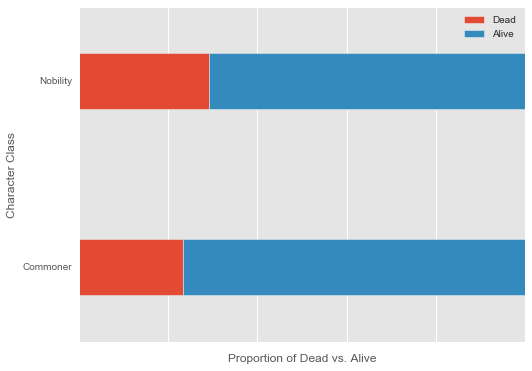

In [276]:
data = predictions.groupby(["isNoble", "isAlive"]).count()["name"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .3, figsize=(8,6))
_ = p.set(yticklabels = ["Commoner", "Nobility"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Character Class"), p.legend(["Dead", "Alive"])

### How have marriages been affected by the high death tolls? 

Looks like most characters are unmarried or we don't have information on whether or not they are married. A high percentage of spouses of characters with spouses are still alive. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1251e59d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x125771550>], dtype=object)

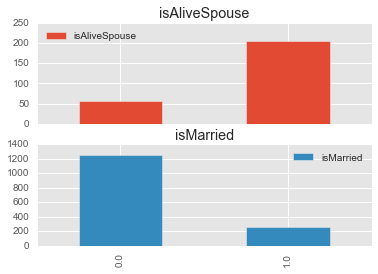

In [277]:
plt.figure(figsize=(12,12))
d = pd.DataFrame({'isMarried': predictions.isMarried, 'isAliveSpouse': predictions.isAliveSpouse})
d.apply(pd.value_counts).plot(kind='bar', subplots=True)

### Which of the major houses suffered the most deaths?

I'm going to select the following houses for comparison: Lannister, Frey, Martell, Tyrell, Stark, Targaryen, Tully, Greyjoy, Arryn, and the Night's watch

In [278]:
# Create boolean variables for each house
Lannister = predictions['house'] == "House Lannister"
Frey = predictions['house'] == "House Frey"
Martell = predictions['house'] == "House Martell"
Tyrell = predictions['house'] == "House Tyrell"
Stark = predictions['house'] == "House Stark"
Targaryen = predictions['house'] == "House Targaryen"
Tully = predictions['house'] == "House Tully"
Greyjoy = predictions['house'] == "House Greyjoy"
Arryn = predictions['house'] == "House Arryn"
Nightswatch = predictions['house'] =="Night's Watch"

# Create variable with TRUE if isAlive == 0 
dead = predictions['isAlive'] == 0

# Select all cases where house is ___ and character is dead
print ("House Lannister:"), predictions[Lannister & dead].isAlive.count()
print ("House Frey:"), predictions[Frey & dead].isAlive.count()
print ("House Martell:"), predictions[Martell & dead].isAlive.count()
print ("House Tyrell:"), predictions[Tyrell & dead].isAlive.count()
print ("House Stark:"), predictions[Stark & dead].isAlive.count()
print ("House Targaryen:"), predictions[Targaryen & dead].isAlive.count()
print ("House Tully:"), predictions[Tully & dead].isAlive.count()
print ("House Greyjoy:"), predictions[Greyjoy & dead].isAlive.count()
print ("House Arryn:"), predictions[Arryn & dead].isAlive.count()

House Lannister: 18
House Frey: 14
House Martell: 4
House Tyrell: 2
House Stark: 22
House Targaryen: 41
House Tully: 7
House Greyjoy: 14
House Arryn: 6


It turns out that House Targaryen suffered the most number of deaths, followed by House Stark. This makes sense as the Targaryen family was wiped out before the beginning of the series and House Stark has since then been mostly annihilated by its enemies as well. I'm going to create a new feature that has contains the top 3 houses with the highest death toll. 

### Summary of the Explorational Analysis 

- The data set that I'm looking at after cleaning has 1519 observations and 26 columns/features
- Women are more likely to survive than men
- Commoners are more likley to survive when compared to the noble class
- Most characters are unmarried
- House Targaryen suffered the most number of deaths

### Feature Engineering

In [279]:
#Creating a new boolean feature for whether or not a character belongs to most unfortunate houses 
predictions['badluckhouses'] = np.where(predictions['house'] == "House Lannister", True, False)
predictions['badluckhouses'] = np.where(predictions['house'] == "House Stark", True, False)
predictions['badluckhouses'] = np.where(predictions['house'] == "House Targaryen", True, False)

In [280]:
#Here I'm double checking if the feature turned out correct...and it works. 
#Valarr Targaryen of House Targaryen is identified as a member of the 'badluckhouses'
predictions.head()

,name,title,male,culture,mother,father,heir,house,spouse,book1,...,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive,badluckhouses
1,Walder Frey,Lord of the Crossing,1,Rivermen,NaN,NaN,NaN,House Frey,Perra Royce,1,...,1.0,1,1,97.0,1,1,1,0.896321,1,False
2,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,House Swyft,NaN,0,...,NaN,0,1,NaN,0,0,0,0.267559,1,False
3,Aemma Arryn,Queen,0,NaN,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,...,0.0,1,1,23.0,0,0,0,0.183946,0,False
4,Sylva Santagar,Greenstone,0,Dornish,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,...,1.0,1,1,29.0,0,0,0,0.043478,1,False
6,Valarr Targaryen,Hand of the King,1,Valyrian,NaN,NaN,NaN,House Targaryen,Kiera of Tyrosh,0,...,1.0,1,1,26.0,0,0,1,0.431438,0,True


### Correlations

In [281]:
#Finding the correlations 
predictions.corr()

,male,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive,badluckhouses
male,1.000000,0.098621,0.058499,0.035639,-0.051716,0.083030,NaN,NaN,NaN,0.242687,-0.091761,0.186958,0.087690,0.005911,0.031178,0.111716,0.114316,-0.136998,-0.049561
book1,0.098621,1.000000,0.411571,0.259365,0.082689,0.276324,NaN,NaN,NaN,0.081662,0.068641,0.080835,-0.105250,0.255788,0.278294,0.311605,0.399469,-0.148420,0.017976
book2,0.058499,0.411571,1.000000,0.485758,0.203473,0.219118,NaN,NaN,NaN,0.069108,0.133213,-0.005813,-0.054908,0.123557,0.150884,0.191691,0.314390,-0.053686,-0.067947
book3,0.035639,0.259365,0.485758,1.000000,0.394086,0.273822,NaN,NaN,NaN,0.095255,0.119850,-0.017409,0.028136,0.111505,0.160710,0.177242,0.288954,0.013176,-0.090703
book4,-0.051716,0.082689,0.203473,0.394086,1.000000,0.375727,NaN,NaN,NaN,0.216068,0.108880,0.031265,0.036520,0.055972,0.085376,0.104653,0.196822,0.291318,-0.133678
book5,0.083030,0.276324,0.219118,0.273822,0.375727,1.000000,NaN,NaN,NaN,0.135018,0.058059,0.094312,0.012597,0.165767,0.212134,0.180815,0.273713,0.081801,0.004650
isAliveMother,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isAliveFather,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isAliveHeir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isAliveSpouse,0.242687,0.081662,0.069108,0.095255,0.216068,0.135018,NaN,NaN,NaN,1.000000,NaN,-0.000313,0.029252,-0.216696,-0.180672,-0.035905,-0.079872,0.183096,-0.199595


In [282]:
#double checking the variable types here because I had trouble running models where the string values could not be converted into float64 values. 
predictions.dtypes

name                  object
title                 object
male                   int64
culture               object
mother                object
father                object
heir                  object
house                 object
spouse                object
book1                  int64
book2                  int64
book3                  int64
book4                  int64
book5                  int64
isAliveMother        float64
isAliveFather        float64
isAliveHeir          float64
isAliveSpouse        float64
isMarried              int64
isNoble                int64
age                  float64
numDeadRelations       int64
boolDeadRelations      int64
isPopular              int64
popularity           float64
isAlive                int64
badluckhouses           bool
dtype: object

### Logistic Regression

In [283]:
from sklearn import tree
X = predictions[["book1","book2", "book3", "book4", "book5","male", "isNoble", "isPopular", "popularity", "numDeadRelations", "badluckhouses",]]
y = predictions.isAlive

In [284]:
# Splitting the data into test and train data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)

In [285]:
print len(X_train)
print len(X_test)
print len(y_train)
print len(y_test)

911
608
911
608


In [340]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [311]:
#This is a great score
model.score(X_train, y_train)

0.76619099890230513

In [341]:
model.score(X_test, y_test)

0.75822368421052633

### Logistics Regression (Model Validation)

In [315]:
from sklearn.cross_validation import cross_val_score

In [342]:
#10 fold cross validation
scores = cross_val_score(model, X, y, cv=10)
print("Accuracy: " + str(scores.mean()) + " (+/- " + str(scores.std() * 2) + ")")

Accuracy: 0.754413558731 (+/- 0.0499447501987)


In [343]:
c_hat = model.predict(X_test)
pd.crosstab(c_hat, 
    y_test,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,42,29
1,118,419


### Decision Tree

In [344]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [345]:
model.score(X_train, y_train)

0.95718990120746428

In [346]:
#Let's test for overfitting
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [348]:
model.score(X_test, y_test)

0.72039473684210531

### Decision Tree (Model Validation)

In [319]:
from sklearn.cross_validation import cross_val_score

In [320]:
# 10-fold cross-validation error formula
scores = cross_val_score(model, X, y, cv=10)
print("Accuracy: " + str(scores.mean()) + " (+/- " + str(scores.std() * 2) + ")")

Accuracy: 0.73333478564 (+/- 0.0721755888575)


In [337]:
c_hat = model.predict(X_test)
pd.crosstab(c_hat, 
    y_test,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class'])


True Class,0,1
Hypothesized Class,,
0,80,88
1,80,360


In [335]:
y_test

1611    0
917     1
15      1
958     1
1020    0
406     0
1417    1
1445    0
1636    1
1008    1
1467    1
298     0
1170    1
1271    1
425     1
1188    1
971     1
856     1
57      1
87      0
878     1
937     0
772     1
1083    0
1232    1
414     1
483     1
288     1
519     1
1413    1
       ..
1716    1
404     1
1404    1
487     0
1455    1
633     1
577     0
418     1
580     1
1094    1
1803    1
1814    0
1762    1
1867    0
27      1
84      0
1545    1
1905    0
1194    1
564     1
1494    1
1923    1
1795    1
1106    0
1896    1
148     1
1491    1
1727    1
307     1
283     1
Name: isAlive, dtype: int64

### Feature Importance

In [323]:
feature_importances = sorted(zip(model.feature_importances_, X.columns.values), reverse = True)
feature_importances

[(0.50583226332427833, 'popularity'),
 (0.092494451595804481, 'book4'),
 (0.069425919271374051, 'book2'),
 (0.068220976858604426, 'book5'),
 (0.064455721974261082, 'book3'),
 (0.060876552241592531, 'male'),
 (0.047670157953919351, 'isNoble'),
 (0.034803489639473974, 'book1'),
 (0.033354127847828298, 'numDeadRelations'),
 (0.018842143365291726, 'badluckhouses'),
 (0.0040241959275716934, 'isPopular')]

It turns out that the variable that I created `badluckhouses` is not good at predicting life/death. Popularity is the most predictive.

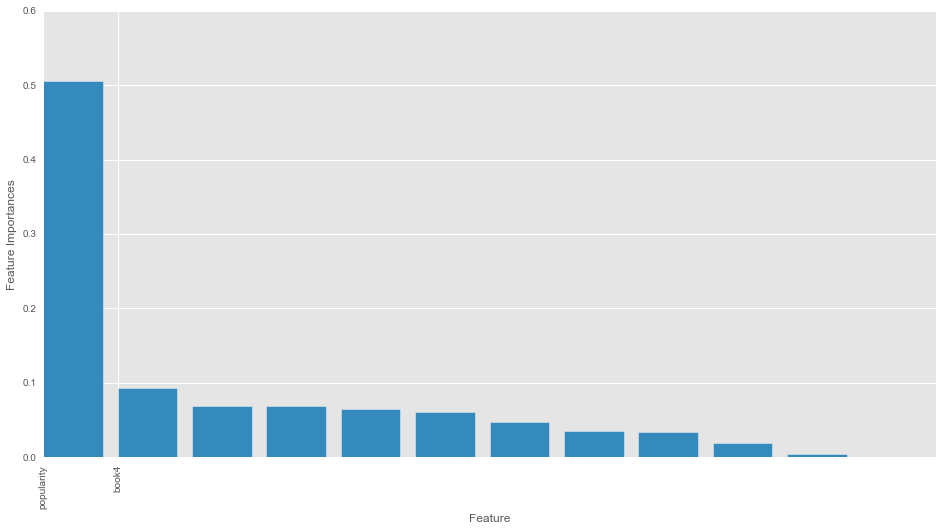

In [324]:
plt.figure(figsize = (16, 8))

plt.bar(
    range(len(feature_importances)),
    [feature_importance[0] for feature_importance in feature_importances]
)

plt.xticks(
    range(len(feature_importance)),
    [feature_importance[1] for feature_importance in feature_importances],
    rotation = 90
)

plt.xlabel('Feature')
plt.ylabel('Feature Importances')


It seems like popularity is the most informative feature and the rest are not really that predictive at all. 

### Conclusions and Next Steps

#### Does death come at random or is there a correlation with the features that I tested? 
It doesn't seem to be random. Popularity is a very strong predictor of death/survival as it accounts. My original assumption that the character's house allegiance by creating the `badluckhouses` did not have fruitful results. It is clear that the differences between Houses isn't particularly interesting. 

#### Can this model be applied to other TV shows/series? 
Probably not for a number of reasons. Firstly, the "unspoken" rule that the main characters generally stay alive does not apply here. Secondly, because there are battles and schemes involved, the character deaths sometimes come in wave, especially when they are house-related deaths.  

#### Why did I choose to use the decision tree classifier vs any other model? 
The decision tree provides a straightforward, easy to understand way of looking at data that can be applied to regressions or classification problems. The decision tree regressor doesn't work as well in this case because the independant variable - isAlive is a cateogorical variable.



#### What else can I look into?

- Assign a likelihood of death score or percentage for each character. I didn't have time to do this after running the model
- Look at other factors such as potential bad decisions made by characters that could have contributed to their demise. This can include pledging allegiance to the weaker house, being in the wrong place in the wrong time, or just being overly brave in general.
- Some of the other datasets contain information such as "latest quotes from the character in the previous TV episode", which can be crucial in plotline prediction.
- Do a bit more feature engineering. For example: look at the total number of books that a character appeared in 


The End